# Obermeyer et al. 2019 experiment

code and data source: https://gitlab.com/labsysmed/dissecting-bias/-/tree/master/code 

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%config InlineBackend.figure_format='retina'

import seaborn as sns

In [2]:
data = pd.read_csv('data_new.csv')
data.shape

(48784, 160)

In [3]:
data.head()

,risk_score_t,program_enrolled_t,cost_t,cost_avoidable_t,bps_mean_t,ghba1c_mean_t,hct_mean_t,cre_mean_t,ldl_mean_t,race,...,trig_min-high_tm1,trig_min-normal_tm1,trig_mean-low_tm1,trig_mean-high_tm1,trig_mean-normal_tm1,trig_max-low_tm1,trig_max-high_tm1,trig_max-normal_tm1,gagne_sum_tm1,gagne_sum_t
0,1.987430,0,1200.0,0.0,NaN,5.4,NaN,1.110000,194.0,white,...,0,0,0,0,0,0,0,0,0,0
1,7.677934,0,2600.0,0.0,119.0,5.5,40.4,0.860000,93.0,white,...,0,1,0,0,1,0,0,1,4,3
2,0.407678,0,500.0,0.0,NaN,NaN,NaN,NaN,NaN,white,...,0,0,0,0,0,0,0,0,0,0
3,0.798369,0,1300.0,0.0,117.0,NaN,NaN,NaN,NaN,white,...,0,0,0,0,0,0,0,0,0,0
4,17.513165,0,1100.0,0.0,116.0,NaN,34.1,1.303333,53.0,white,...,0,0,0,0,0,0,0,0,1,1


## Cost is used as a label but it is not the risk score

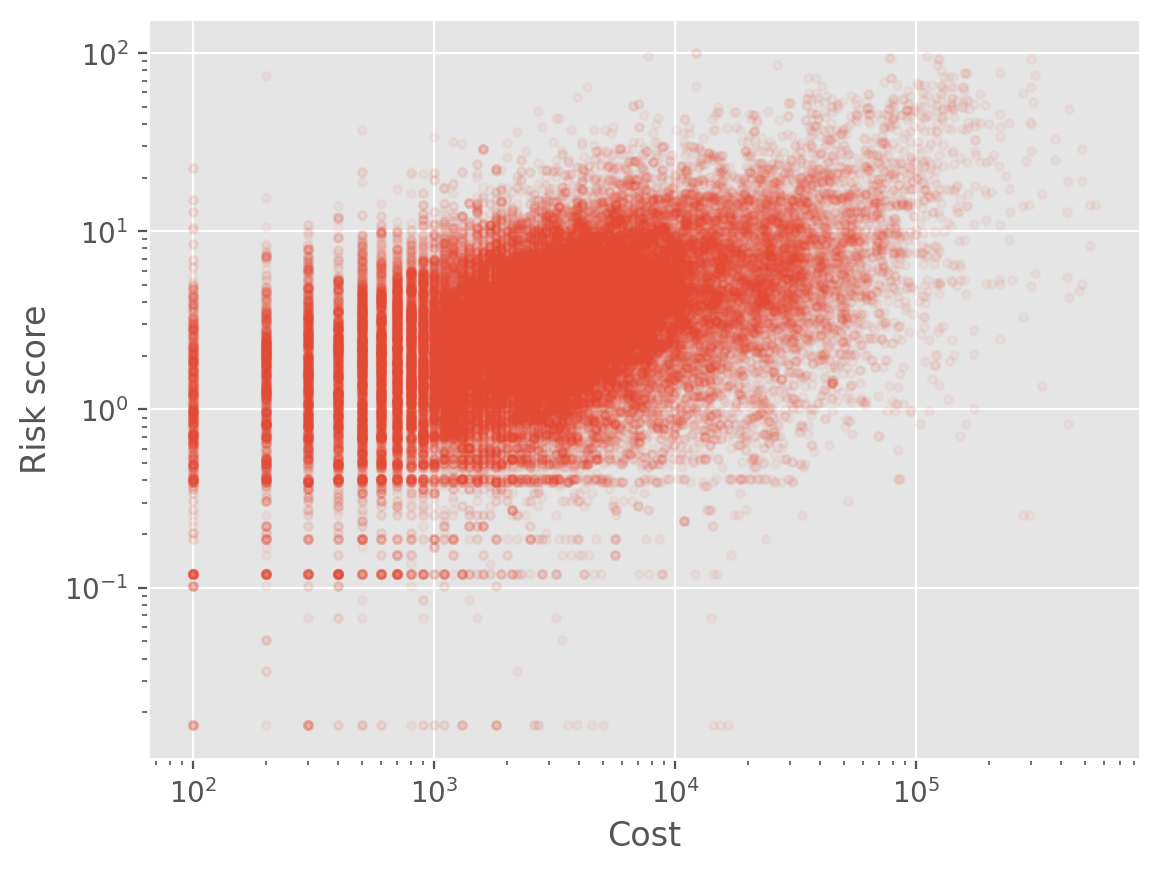

In [4]:
plt.plot(data['cost_t'], data['risk_score_t'], '.', alpha=0.05)
plt.loglog()
plt.xlabel('Cost')
plt.ylabel('Risk score')
plt.show()

## Figure 1B

In [5]:
res_dir = os.path.join(os.getcwd(), 'results')

def setup(default_in_percentile=[95, 97]):
    cohort = pd.read_csv('data_new.csv')
    cohort = cohort[['race', 'risk_score_t', 'gagne_sum_t']]
    dt = cohort.copy()
    dt['risk_pctile'] = pd.cut(dt['risk_score_t'], bins=np.unique(np.percentile(dt['risk_score_t'], np.arange(0, 101))), include_lowest=True, labels=False)
    
    enroll_stats = np.zeros((len(default_in_percentile), 3))
    enroll_stats = pd.DataFrame(enroll_stats, columns=['black_before', 'black_after', 'ratio'])
    enroll_stats.index = default_in_percentile
    
    return {'dt': dt, 'enroll_stats': enroll_stats}

In [6]:
def exercise(default_in_percentile):
    dt = setup(default_in_percentile)['dt']
    enroll_stats = setup(default_in_percentile)['enroll_stats']
    
    for j in range(len(default_in_percentile)):
        prior_enrolled = dt[dt['risk_pctile'] >= default_in_percentile[j]]
        prior_w = prior_enrolled[prior_enrolled['race'] == 'white']
        prior_b = prior_enrolled[prior_enrolled['race'] == 'black']
        
        upperb = dt[(dt['risk_pctile'] >= default_in_percentile[j]) & (dt['race'] == 'black')]
        upperw = dt[(dt['risk_pctile'] >= default_in_percentile[j]) & (dt['race'] == 'white')]
        lowerb = dt[(dt['risk_pctile'] < default_in_percentile[j]) & (dt['race'] == 'black')]
        
        upperw = upperw.sort_values('gagne_sum_t')
        lowerb = lowerb.sort_values(['risk_score_t', 'gagne_sum_t'], ascending=[False, False])
        
        sw = 0
        sb = 0
        switched_count = 0
        switched_w = pd.DataFrame()
        switched_b = pd.DataFrame()
        
        while sb < lowerb.shape[0]:
            if upperw.iloc[sw]['gagne_sum_t'] < lowerb.iloc[sb]['gagne_sum_t']:
                switched_w = switched_w.append(upperw.iloc[sw])
                switched_b = switched_b.append(lowerb.iloc[sb])
                
                upperb = upperb.append(lowerb.iloc[sb])
                
                upperw = upperw.drop(upperw.index[sw])
                upperw = upperw.sort_values('gagne_sum_t')
                
                sb += 1
                switched_count += 1
            else:
                sb += 1
                switched_count = switched_count
        
        sampw = prior_w
        sampb = prior_b
        black_before = prior_b.shape[0] / (prior_w.shape[0] + prior_b.shape[0])
        black_after = (prior_b.shape[0] + switched_count) / (prior_w.shape[0] + prior_b.shape[0])
        ratio = black_after / black_before
        enroll_stats.iloc[j] = [black_before, black_after, ratio]
    
    return enroll_stats

## Examine the `exercise` function for a single given percentile

This function is used to simulate the counterfactual scenario in the paper (Fig. 1B)

In [7]:
default_in_percentile = [97]
j = 0

dt = setup(default_in_percentile)['dt']
enroll_stats = setup(default_in_percentile)['enroll_stats']

prior_enrolled = dt[dt['risk_pctile'] >= default_in_percentile[j]]
prior_w = prior_enrolled[prior_enrolled['race'] == 'white']
prior_b = prior_enrolled[prior_enrolled['race'] == 'black']

upperb = dt[(dt['risk_pctile'] >= default_in_percentile[j]) & (dt['race'] == 'black')]
upperw = dt[(dt['risk_pctile'] >= default_in_percentile[j]) & (dt['race'] == 'white')]
lowerb = dt[(dt['risk_pctile'] < default_in_percentile[j]) & (dt['race'] == 'black')]

upperw = upperw.sort_values('gagne_sum_t')
lowerb = lowerb.sort_values(['risk_score_t', 'gagne_sum_t'], ascending=[False, False])

sw = 0
sb = 0
switched_count = 0
switched_w = pd.DataFrame()
switched_b = pd.DataFrame()

In [8]:
dt.shape

(48784, 4)

In [9]:
dt.head()

,race,risk_score_t,gagne_sum_t,risk_pctile
0,white,1.987430,0,35
1,white,7.677934,3,85
2,white,0.407678,0,3
3,white,0.798369,0,10
4,white,17.513165,1,97


- upperw sorting: healthiest person on top
- lowerb sorting: sickest person on top

In [10]:
upperw.iloc[sw]['gagne_sum_t'], lowerb.iloc[sb]['gagne_sum_t']

(0, 12)

Distribution of comorbidity score in white-upper and black-upper in the original data (based on the original cost algorithm)

In [11]:
upperb_ = upperb.copy()
upperw_ = upperw.copy()
lowerb_ = lowerb.copy()

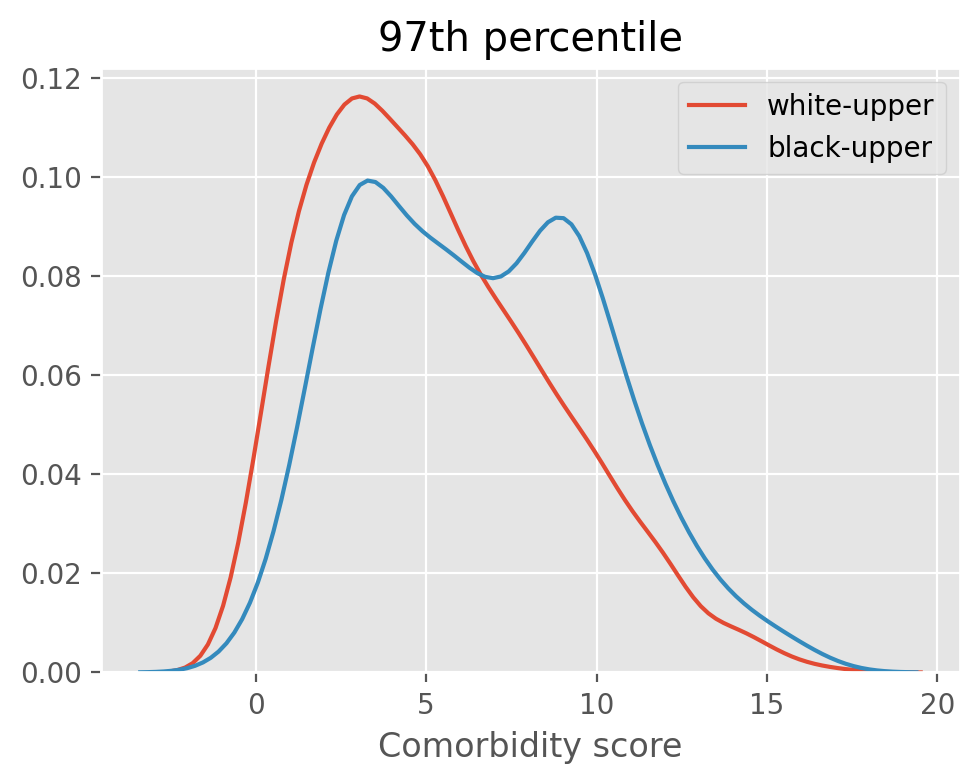

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
sns.kdeplot(upperw_['gagne_sum_t'], label='white-upper', ax=ax)
sns.kdeplot(upperb_['gagne_sum_t'], label='black-upper', ax=ax)
# sns.kdeplot(lowerb_['gagne_sum_t'], label='black-lower', ax=ax)
ax.set(xlabel='Comorbidity score', title='97th percentile')
fig.tight_layout()

How the swapping works:
1. at a given percentile (e.g., 97th percentile) based on the risk score (cost algo)
2. identify whites who are above, identify blacks who are above and below cutoff
3. if the healthiest white-upper's comorbidity < sickest black-lower's comorbidity 
   (= if the healthist white-upper is healthier than the sickest black-lower)
4. remove the healthiest white (white-upper) 
5. and give this spot to the sickest black from black-below (move them to the black-upper)
6. check all blacks in black-below

In [13]:
while sb < lowerb.shape[0]:
    if upperw.iloc[sw]['gagne_sum_t'] < lowerb.iloc[sb]['gagne_sum_t']:
        switched_w = switched_w.append(upperw.iloc[sw])
        switched_b = switched_b.append(lowerb.iloc[sb])

        upperb = upperb.append(lowerb.iloc[sb])
        upperw = upperw.drop(upperw.index[sw])
        upperw = upperw.sort_values('gagne_sum_t')
        
        sb += 1
        switched_count += 1
    else:
        sb += 1
        switched_count = switched_count

Comparing the distribution of comorbidity score between before and after

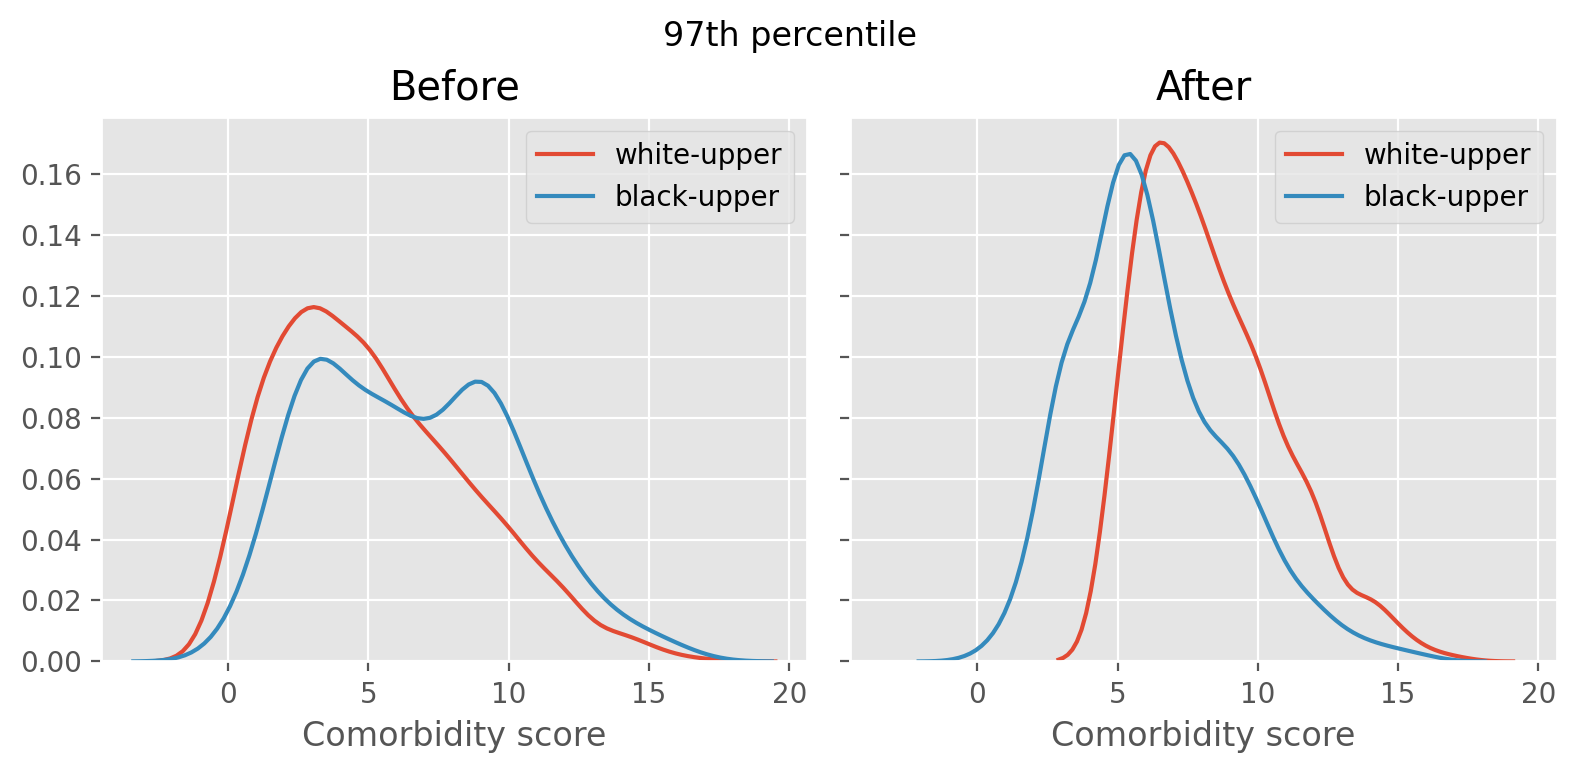

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
sns.kdeplot(upperw_['gagne_sum_t'], label='white-upper', ax=axes[0])
sns.kdeplot(upperb_['gagne_sum_t'], label='black-upper', ax=axes[0])
axes[0].set(xlabel='Comorbidity score', title='Before')

sns.kdeplot(upperw['gagne_sum_t'], label='white-upper', ax=axes[1])
sns.kdeplot(upperb['gagne_sum_t'], label='black-upper', ax=axes[1])
axes[1].set(xlabel='Comorbidity score', title='After')

fig.suptitle('97th percentile', x=0.5, y=0.95)
fig.tight_layout()

## Table 2

In [15]:
def get_concentration_metric_df(k, holdout_pred_df,
                                y_predictors=['log_cost_t',
                                              'log_cost_avoidable_t',
                                              'gagne_sum_t'],
                                outcomes=['log_cost_t', 'log_cost_avoidable_t',
                                          'gagne_sum_t', 'dem_race_black']):
    """Calculate concentration of a given outcome of interest (columns) for
    each algorithm trained label, and calculate fraction black in the high-risk
    patient group.

    Parameters
    ----------
    k : float
        Top k% patients in terms of predicted risk.
    holdout_pred_df : pd.DataFrame
        Predictions for holdout set.
    y_predictors : list
        List of algorithm training label.
    outcomes : list
        List of given outcome of interest.

    Returns
    -------
    pd.DataFrame
        Concentration metric for holdout_pred_df.
    """
    # define lookup for human readable headings in Table 2
    OUTCOME_DICT = {
        'cost_t': 'Total costs',
        'log_cost_t': 'Total costs',
        'cost_avoidable_t': 'Avoidable costs',
        'log_cost_avoidable_t': 'Avoidable costs',
        'gagne_sum_t': 'Active chronic conditions',
        'dem_race_black': 'Race black'
    }

    top_k = int(k * len(holdout_pred_df))
    all_concentration_metric = []  # save all rows of Table 2 to variable

    # iterate through each predictor (algorithm training label)
    # (this is each row in Table 2)
    for y_col in y_predictors:
        # get the predictions column name for y_col
        y_hat_col = '{}_hat'.format(y_col)

        # sort by y_hat_col
        holdout_pred_df = holdout_pred_df.sort_values(by=y_hat_col, ascending=False)
        # get top k% in terms of predicted risk
        top_k_df = holdout_pred_df.iloc[:top_k]

        # define dict to store calculated metrics for given y_col/predictor
        # (each addition to the dict appends a column from Table 2)
        concentration_dict = {
            'predictor': OUTCOME_DICT[y_col]
        }

        # iterate through each outcome
        # (concentration / frac black in highest-risk patients)
        # (this is each column in Table 2)
        for outcome in outcomes:
            if 'log_' in outcome:
                # for the outcomes presented on a log scale,
                # we sum the un-logged values.
                outcome = outcome[len('log_'):]

            # define numerator of concentration metric:
            # sum the top k of outcome
            top_k_outcome = top_k_df[outcome].sum()

            # define denominator of concentration metric
            if outcome == 'dem_race_black':
                # for fraction black in highest-risk patients,
                # denominator is the n of top k%
                total_outcome = top_k
            else:
                # for concentration in highest-risk patients,
                # denominator is the total sum of the entire holdout
                total_outcome = holdout_pred_df[outcome].sum()

            # calculate concentration metric
            frac_top_k = top_k_outcome / total_outcome

            # add column to concentration_dict (row)
            concentration_dict[OUTCOME_DICT[outcome]] = frac_top_k

            # calculate standard error (SE)
            n = len(holdout_pred_df)
            import math
            # SE = sqrt[ p * (1-p) / n]
            se = math.sqrt((frac_top_k * (1-frac_top_k))/n)

            # add SE column to concentration_dict (row)
            concentration_dict[OUTCOME_DICT[outcome] + ' SE'] = se
        all_concentration_metric.append(concentration_dict)

    # convert to pd.DataFrame for pretty formatting
    concentration_df = pd.DataFrame(all_concentration_metric)
    concentration_df = concentration_df.set_index('predictor')

    # define column order of Table 2
    column_order = []
    for outcome in outcomes:
        outcome = OUTCOME_DICT[outcome]
        column_order.append(outcome)
        column_order.append(outcome + ' SE')

    return concentration_df[column_order]


In [16]:
holdout_pred_df = pd.read_csv('model_lasso_predictors.csv')
holdout_pred_df.head()

,index,dem_race_black,risk_score_t,gagne_sum_t,cost_t,cost_avoidable_t,program_enrolled_t,log_cost_t_hat,gagne_sum_t_hat,log_cost_avoidable_t_hat,risk_score_t_percentile
0,2,0,0.407678,0,500.0,0.0,0,3.012857,0.107439,0.534697,4
1,5,0,4.450484,1,123700.0,0.0,0,3.985548,2.423606,2.113413,69
2,10,0,0.713436,0,1500.0,0.0,0,2.820869,0.091171,0.363918,10
3,11,0,3.940887,1,21500.0,500.0,0,3.116980,0.788215,0.800114,63
4,13,0,1.919484,0,2800.0,300.0,0,3.186166,0.143811,0.476029,35


In [17]:
y_hat_col = 'log_cost_t_hat'
holdout_pred_df = holdout_pred_df.sort_values(by=y_hat_col, ascending=False)

In [18]:
# get top k% in terms of predicted risk
k = 0.03
top_k = int(k * len(holdout_pred_df))
top_k_df = holdout_pred_df.iloc[:top_k]

In [19]:
outcome = 'cost_avoidable_t'
top_k_outcome = top_k_df[outcome].sum()
top_k_outcome

8972400.0

In [20]:
total_outcome = holdout_pred_df[outcome].sum()
total_outcome

38309600.0

In [21]:
frac_top_k = top_k_outcome / total_outcome
frac_top_k

0.2342076137573872